# Overview

We simulate a neutron monochromator energy calibration scan using Bluesky for experiment control.
A monochromator crystal selects neutrons of specific energy $E$ by rotating to angle $\theta$ according to Bragg's law:

$$
E = \frac{h^2}{2m_n \lambda^2} = \frac{h^2}{8m_n d^2 \sin^2(\theta)}
$$

where
$d$ = 3.354 Å (PG002 crystal d-spacing),
$m_n$ = neutron mass,
$h$ = Planck's constant.

## Virtual Devices Required

1. Energy Selector (Monochromator): Ophyd device that:
  - Sets neutron energy by adjusting crystal angle
  - Uses TAVI's MonoAna class for $E \leftrightarrow \theta$ conversions
  - Simulates motor movement with realistic delays
2. Virtual Detector: Simple point detector that:
  - Returns intensity counts based on selected energy
  - Simulates a Gaussian peak centered at 14.7 meV (elastic scattering from sample)
  - Adds Poisson noise for realism

## Experimental Workflow

1. Setup: Initialize monochromator with PG002 crystal parameters
2. Scan: Use Bluesky to scan monochromator energy from 5 to 25 meV
3. Measure: At each energy, record detector intensity
4. Analyze: Plot intensity vs energy, expect peak at 14.7 meV
5. Validate: Confirm energy selection and device integration

This experiment demonstrates Bluesky's core concepts: devices, plans, run engine, and data collection.

In [1]:
# Standard library imports
import time
from typing import Any, Dict, Optional

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# Bluesky imports
from bluesky import RunEngine
from bluesky.callbacks import LivePlot, LiveTable
from bluesky.plans import count, scan
from bluesky.simulators import check_limits, summarize_plan

# Ophyd imports
from ophyd import Component as Cpt
from ophyd import Device, Signal
from ophyd.status import DeviceStatus

# TAVI imports for neutron physics calculations
from tavi.instrument.components.mono_ana import MonoAna

# Configure matplotlib for inline display
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

## Virtual Device Definitions

### Energy Selector Device

In [ ]:
class EnergySelectorDevice(Device):
    """
    Virtual energy selector device (monochromator/analyzer) for neutron instruments.

    This device simulates a crystal monochromator that selects neutron energy
    by rotating to specific Bragg angles. It uses TAVI's MonoAna class for
    accurate physics calculations.

    Parameters
    ----------
    crystal_params : dict
        Crystal parameters including type and sense
        Example: {"type": "PG002", "sense": "-"}
    name : str
        Device name for Bluesky

    Attributes
    ----------
    energy : Signal
        Target/readback energy in meV (this is what we scan)
    theta : Signal
        Bragg angle in degrees (calculated from energy)
    two_theta : Signal
        Detector angle in degrees (2 * theta)

    Examples
    --------
    >>> mono_params = {"type": "PG002", "sense": "-"}
    >>> mono = EnergySelectorDevice(mono_params, name="mono")
    >>> mono.set(14.7).wait()  # Set to 14.7 meV
    """

    # Device components with type hints via Cpt
    energy: Signal = Cpt(Signal, value=10.0, kind="hinted")
    theta: Signal = Cpt(Signal, value=0.0, kind="config")
    two_theta: Signal = Cpt(Signal, value=0.0, kind="config")

    def __init__(
        self, crystal_params: Dict[str, Any], name: str = "energy_selector", **kwargs
    ):
        """Initialize the energy selector with crystal parameters."""
        super().__init__(name=name, **kwargs)

        # Initialize TAVI MonoAna for physics calculations
        self.crystal = MonoAna(param_dict=crystal_params, component_name=name)

        # Set initial energy
        self.energy.set(10.0)
        self._update_angles_from_energy(10.0)

    def _update_angles_from_energy(self, energy: float) -> None:
        """
        Update theta and two_theta based on energy.

        Parameters
        ----------
        energy : float
            Neutron energy in meV
        """
        try:
            theta = self.crystal.get_bragg_angle_from_energy(energy)
            if not np.isnan(theta):
                self.theta.set(theta)
                self.two_theta.set(2 * theta)
        except Exception as e:
            print(f"Warning: Could not calculate angles for energy {energy}: {e}")

    def set(self, energy: float) -> DeviceStatus:
        """
        Set the monochromator to select a specific neutron energy.

        This method simulates motor movement by:
        1. Calculating required Bragg angle
        2. Moving theta and two_theta motors
        3. Simulating movement time

        Parameters
        ----------
        energy : float
            Target neutron energy in meV

        Returns
        -------
        DeviceStatus
            Status object that completes when movement is done
        """
        status = DeviceStatus(self, timeout=5.0)

        def move():
            """Simulate the motor movement."""
            try:
                # Check if energy is physically achievable
                theta = self.crystal.get_bragg_angle_from_energy(energy)
                if np.isnan(theta):
                    status.set_exception(
                        ValueError(
                            f"Energy {energy} meV not achievable with {self.crystal.type} crystal"
                        )
                    )
                    return

                # Update all signals
                self.energy.set(energy)
                self._update_angles_from_energy(energy)

                # Simulate movement time (proportional to angle change)
                old_theta = self.theta.get()
                movement_time = min(0.1 + abs(theta - old_theta) * 0.01, 2.0)
                time.sleep(movement_time)

                status.set_finished()

            except Exception as e:
                status.set_exception(e)

        # Start movement in background (in real device, this would be threaded)
        move()

        return status

    def describe(self) -> Dict[str, Dict[str, Any]]:
        """
        Describe the device for Bluesky.

        This must match what read() returns.

        Returns
        -------
        dict
            Description of data fields
        """
        return {
            f"{self.name}_energy": {
                "source": f"{self.name}.energy",
                "dtype": "number",
                "shape": [],
                "units": "meV",
                "lower_ctrl_limit": 2.0,  # Virtual limit for demo
                "upper_ctrl_limit": 50.0,  # Virtual limit for demo
            }
        }

    def read(self) -> Dict[str, Dict[str, Any]]:
        """
        Read the current device state.

        Returns
        -------
        dict
            Dictionary with energy value and timestamp
        """
        return {
            f"{self.name}_energy": {
                "value": self.energy.get(),
                "timestamp": time.time(),
            }
        }

    def read_configuration(self) -> Dict[str, Dict[str, Any]]:
        """
        Read device configuration including crystal parameters.

        Returns
        -------
        dict
            Configuration dictionary with crystal info and angles
        """
        return {
            f"{self.name}_crystal_type": {
                "value": self.crystal.type,
                "timestamp": time.time(),
            },
            f"{self.name}_d_spacing": {
                "value": self.crystal.d_spacing,
                "timestamp": time.time(),
            },
            f"{self.name}_theta": {"value": self.theta.get(), "timestamp": time.time()},
            f"{self.name}_two_theta": {
                "value": self.two_theta.get(),
                "timestamp": time.time(),
            },
        }

    def describe_configuration(self) -> Dict[str, Dict[str, Any]]:
        """
        Describe configuration for Bluesky.

        Returns
        -------
        dict
            Description of configuration fields
        """
        return {
            f"{self.name}_crystal_type": {
                "source": f"{self.name}.crystal_type",
                "dtype": "string",
                "shape": [],
            },
            f"{self.name}_d_spacing": {
                "source": f"{self.name}.d_spacing",
                "dtype": "number",
                "shape": [],
                "units": "Angstrom",
            },
            f"{self.name}_theta": {
                "source": f"{self.name}.theta",
                "dtype": "number",
                "shape": [],
                "units": "degrees",
            },
            f"{self.name}_two_theta": {
                "source": f"{self.name}.two_theta",
                "dtype": "number",
                "shape": [],
                "units": "degrees",
            },
        }


# Create monochromator instance
mono_params = {"type": "PG002", "sense": "-"}
mono = EnergySelectorDevice(mono_params, name="mono")
print(f"Monochromator initialized with {mono.crystal.type} crystal")
print(f"d-spacing: {mono.crystal.d_spacing:.4f} Å")
print(f"Initial energy: {mono.energy.get():.1f} meV")

# Test that describe() and read() match
print("\n✅ Device implements Bluesky protocol:")
print(f"  read() keys: {list(mono.read().keys())}")
print(f"  describe() keys: {list(mono.describe().keys())}")
print("  Keys match: ", set(mono.read().keys()) == set(mono.describe().keys()))

Monochromator initialized with PG002 crystal
d-spacing: 3.3542 Å
Initial energy: 10.0 meV

✅ Device implements Bluesky protocol:
  read() keys: ['mono_energy']
  describe() keys: ['mono_energy']
  Keys match:  True


### Virtual Detector Device


In [3]:
class VirtualNeutronDetector(Device):
    """
    Virtual neutron detector that simulates intensity based on monochromator energy.

    This detector simulates elastic scattering from a sample with a characteristic
    excitation at 14.7 meV. The intensity follows a Gaussian profile centered at
    this energy, with added Poisson noise for realism.

    Parameters
    ----------
    monochromator : EnergySelectorDevice
        The monochromator device to read energy from
    peak_energy : float, optional
        Energy of the elastic peak in meV (default: 14.7)
    peak_intensity : float, optional
        Maximum counts at peak energy (default: 10000)
    peak_width : float, optional
        FWHM of the peak in meV (default: 0.5)
    background : float, optional
        Background count level (default: 100)
    name : str, optional
        Device name for Bluesky (default: "detector")

    Attributes
    ----------
    counts : Signal
        Detected neutron counts

    Examples
    --------
    >>> detector = VirtualNeutronDetector(mono, peak_energy=14.7)
    >>> detector.trigger()  # Simulate measurement
    >>> detector.read()  # Get counts
    """

    counts: Signal = Cpt(Signal, value=0, kind="hinted")
    exposure_time: Signal = Cpt(Signal, value=1.0, kind="config")

    def __init__(
        self,
        monochromator: EnergySelectorDevice,
        peak_energy: float = 14.7,
        peak_intensity: float = 10000,
        peak_width: float = 0.5,
        background: float = 100,
        name: str = "detector",
        **kwargs,
    ):
        """Initialize the virtual detector with simulation parameters."""
        super().__init__(name=name, **kwargs)

        self.monochromator = monochromator
        self.peak_energy = peak_energy
        self.peak_intensity = peak_intensity
        self.peak_width = peak_width
        self.background = background

        # Convert FWHM to sigma for Gaussian
        self.sigma = peak_width / (2 * np.sqrt(2 * np.log(2)))

    def _calculate_intensity(self, energy: float) -> float:
        """
        Calculate expected intensity for given energy.

        Parameters
        ----------
        energy : float
            Neutron energy in meV

        Returns
        -------
        float
            Expected counts (before noise)
        """
        # Gaussian peak centered at peak_energy
        gaussian = np.exp(-0.5 * ((energy - self.peak_energy) / self.sigma) ** 2)
        intensity = self.background + self.peak_intensity * gaussian

        # Scale by exposure time
        intensity *= self.exposure_time.get()

        return intensity

    def trigger(self) -> DeviceStatus:
        """
        Trigger a measurement (simulate neutron counting).

        This method:
        1. Reads current monochromator energy
        2. Calculates expected intensity
        3. Adds Poisson noise
        4. Updates counts signal

        Returns
        -------
        DeviceStatus
            Status object that completes when measurement is done
        """
        status = DeviceStatus(self, timeout=5.0)

        def measure():
            """Simulate the measurement."""
            try:
                # Get current energy from monochromator
                energy = self.monochromator.energy.get()

                # Calculate expected intensity
                expected_counts = self._calculate_intensity(energy)

                # Add Poisson noise for realism
                measured_counts = np.random.poisson(expected_counts)

                # Simulate measurement time
                time.sleep(self.exposure_time.get() * 0.1)  # Scaled down for demo

                # Update counts
                self.counts.set(measured_counts)

                status.set_finished()

            except Exception as e:
                status.set_exception(e)

        # Start measurement
        measure()

        return status

    def read(self) -> Dict[str, Dict[str, Any]]:
        """
        Read the current detector counts.

        Returns
        -------
        dict
            Dictionary with counts value and timestamp
        """
        return {
            f"{self.name}_counts": {
                "value": self.counts.get(),
                "timestamp": time.time(),
            }
        }

    def read_configuration(self) -> Dict[str, Dict[str, Any]]:
        """
        Read detector configuration.

        Returns
        -------
        dict
            Configuration dictionary with detector parameters
        """
        return {
            f"{self.name}_peak_energy": {
                "value": self.peak_energy,
                "timestamp": time.time(),
            },
            f"{self.name}_peak_width": {
                "value": self.peak_width,
                "timestamp": time.time(),
            },
            f"{self.name}_exposure_time": {
                "value": self.exposure_time.get(),
                "timestamp": time.time(),
            },
        }

    def describe(self) -> Dict[str, Dict[str, Any]]:
        """
        Describe the detector output format.

        Returns
        -------
        dict
            Description of data fields
        """
        return {
            f"{self.name}_counts": {
                "source": "Virtual detector simulation",
                "dtype": "number",
                "shape": [],
                "units": "counts",
            }
        }


# Create detector instance linked to monochromator
detector = VirtualNeutronDetector(
    mono,
    peak_energy=14.7,
    peak_intensity=10000,
    peak_width=0.5,
    background=100,
    name="detector",
)

print("Virtual detector initialized")
print(f"Peak at {detector.peak_energy} meV with width {detector.peak_width} meV")
print(f"Peak intensity: {detector.peak_intensity} counts")
print(f"Background: {detector.background} counts")

# Test the detector
mono.set(14.7).wait()
detector.trigger().wait()
print(f"\nTest measurement at 14.7 meV: {detector.counts.get()} counts")

Virtual detector initialized
Peak at 14.7 meV with width 0.5 meV
Peak intensity: 10000 counts
Background: 100 counts

Test measurement at 14.7 meV: 10156 counts


## Visualization Callbacks

In [4]:
def create_live_table(devices: list) -> LiveTable:
    """
    Create a LiveTable callback for real-time data display.

    Parameters
    ----------
    devices : list
        List of devices to monitor

    Returns
    -------
    LiveTable
        Configured LiveTable callback

    Examples
    --------
    >>> table = create_live_table([mono, detector])
    >>> RE(scan([detector], mono, 5, 25, 21), table)
    """
    # Extract field names from devices
    fields = []
    for device in devices:
        if hasattr(device, "hints"):
            hints = device.hints.get("fields", [])
            fields.extend(hints)
        else:
            # Fallback to device name
            fields.append(f"{device.name}")

    # Add default fields if not present
    if "mono_energy" not in fields:
        fields.insert(0, "mono_energy")
    if "detector_counts" not in fields:
        fields.append("detector_counts")

    return LiveTable(fields)


def create_live_plot(
    x_field: str = "mono_energy",
    y_field: str = "detector_counts",
    ax: Optional[plt.Axes] = None,
) -> LivePlot:
    """
    Create a LivePlot callback for real-time plotting.

    Parameters
    ----------
    x_field : str, optional
        Field name for x-axis (default: 'mono_energy')
    y_field : str, optional
        Field name for y-axis (default: 'detector_counts')
    ax : matplotlib.axes.Axes, optional
        Axes to plot on. If None, creates new figure

    Returns
    -------
    LivePlot
        Configured LivePlot callback

    Examples
    --------
    >>> plot = create_live_plot()
    >>> RE(scan([detector], mono, 5, 25, 21), plot)
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    plot = LivePlot(
        y_field,
        x=x_field,
        ax=ax,
        marker="o",
        markersize=8,
        markerfacecolor="blue",
        markeredgecolor="darkblue",
        linestyle="-",
        linewidth=1,
        color="blue",
        alpha=0.7,
    )

    # Configure axes
    ax.set_xlabel("Energy (meV)", fontsize=12)
    ax.set_ylabel("Counts", fontsize=12)
    ax.set_title("Energy Scan", fontsize=14, fontweight="bold")
    ax.grid(True, alpha=0.3)

    return plot


def create_peak_finder_callback(
    x_field: str = "mono_energy",
    y_field: str = "detector_counts",
    threshold: float = 0.5,
) -> callable:
    """
    Create a callback that identifies peaks during scanning.

    This callback analyzes data in real-time and prints when
    a peak is detected based on relative intensity.

    Parameters
    ----------
    x_field : str, optional
        Field name for x-axis (default: 'mono_energy')
    y_field : str, optional
        Field name for y-axis (default: 'detector_counts')
    threshold : float, optional
        Peak threshold as fraction of max intensity (default: 0.5)

    Returns
    -------
    callable
        Callback function for peak detection

    Examples
    --------
    >>> peak_finder = create_peak_finder_callback(threshold=0.7)
    >>> RE(scan([detector], mono, 5, 25, 21), peak_finder)
    """
    peak_data = {"x": [], "y": [], "max_y": 0}

    def peak_finder(name: str, doc: Dict[str, Any]) -> None:
        """Process documents and identify peaks."""
        if name == "event":
            # Extract data from event document
            data = doc["data"]
            if x_field in data and y_field in data:
                x_val = data[x_field]
                y_val = data[y_field]

                peak_data["x"].append(x_val)
                peak_data["y"].append(y_val)

                # Update maximum
                if y_val > peak_data["max_y"]:
                    peak_data["max_y"] = y_val

                # Check if this is a peak
                if y_val > threshold * peak_data["max_y"] and peak_data["max_y"] > 0:
                    print(
                        f"📍 Peak detected at {x_val:.2f} meV with {y_val:.0f} counts"
                    )

        elif name == "stop":
            # Final analysis at end of scan
            if peak_data["x"] and peak_data["y"]:
                # Find the highest peak
                max_idx = np.argmax(peak_data["y"])
                peak_energy = peak_data["x"][max_idx]
                peak_counts = peak_data["y"][max_idx]

                print(f"\n✅ Scan complete!")
                print(f"   Main peak: {peak_energy:.2f} meV")
                print(f"   Peak intensity: {peak_counts:.0f} counts")

                # Calculate FWHM if enough data
                if len(peak_data["y"]) > 5:
                    half_max = peak_counts / 2
                    above_half = np.array(peak_data["y"]) > half_max
                    if np.any(above_half):
                        indices = np.where(above_half)[0]
                        energy_range = np.array(peak_data["x"])[indices]
                        fwhm = energy_range[-1] - energy_range[0]
                        print(f"   Estimated FWHM: {fwhm:.2f} meV")

            # Reset for next scan
            peak_data["x"].clear()
            peak_data["y"].clear()
            peak_data["max_y"] = 0

    return peak_finder


# Test the callbacks
print("Visualization callbacks created successfully!")
print("\nAvailable callbacks:")
print("  - create_live_table(): Real-time data table")
print("  - create_live_plot(): Real-time plot")
print("  - create_peak_finder_callback(): Peak detection")
print("\nThese will be used during scan execution.")

Visualization callbacks created successfully!

Available callbacks:
  - create_live_table(): Real-time data table
  - create_live_plot(): Real-time plot
  - create_peak_finder_callback(): Peak detection

These will be used during scan execution.


## Experiment Plans

### Basic scan plan

In [5]:
# Basic energy calibration scan plan
energy_calibration_scan = scan(
    [detector],  # Detectors to read
    mono,  # Motor to scan
    5,  # Start energy (meV)
    25,  # End energy (meV)
    21,  # Number of points
    md={"sample": "calibration", "purpose": "energy_calibration"},  # Metadata
)

print("Basic scan plan created:")
print("  - Scan mono from 5 to 25 meV in 21 steps")
print("  - Read detector at each point")
print("  - Metadata included for data management")

Basic scan plan created:
  - Scan mono from 5 to 25 meV in 21 steps
  - Read detector at each point
  - Metadata included for data management


### Custom plans

In [6]:
def adaptive_peak_scan(
    detector: Device,
    motor: Device,
    start: float,
    stop: float,
    initial_points: int = 11,
    peak_threshold: float = 0.5,
):
    """
    Custom plan that performs an adaptive scan around detected peaks.

    This plan does a coarse scan first, identifies peaks, then performs
    a fine scan around the peak region for better resolution.

    Parameters
    ----------
    detector : Device
        Detector device to read
    motor : Device
        Motor device to scan
    start : float
        Start position
    stop : float
        Stop position
    initial_points : int, optional
        Number of points in coarse scan (default: 11)
    peak_threshold : float, optional
        Threshold for peak detection as fraction of max over background (default: 0.5)
        Fine scan only happens if peak is significant enough

    Yields
    ------
    Msg
        Bluesky messages for plan execution

    Examples
    --------
    >>> RE(adaptive_peak_scan(detector, mono, 5, 25))
    """
    from bluesky.plan_stubs import mv, trigger_and_read

    # Phase 1: Coarse scan
    print(f"Phase 1: Coarse scan from {start} to {stop} meV")

    coarse_data = {"energy": [], "counts": []}

    # Perform coarse scan
    step = (stop - start) / (initial_points - 1)
    for i in range(initial_points):
        energy = start + i * step

        # Move motor
        yield from mv(motor, energy)

        # Trigger and read detector
        reading = yield from trigger_and_read([motor, detector])

        # Store data
        coarse_data["energy"].append(reading["mono_energy"]["value"])
        coarse_data["counts"].append(reading["detector_counts"]["value"])

    # Find peak in coarse data
    max_idx = np.argmax(coarse_data["counts"])
    peak_energy = coarse_data["energy"][max_idx]
    peak_counts = coarse_data["counts"][max_idx]

    # Calculate background (average of first and last points)
    background = (coarse_data["counts"][0] + coarse_data["counts"][-1]) / 2

    # Check if peak is significant using threshold
    peak_prominence = (
        (peak_counts - background) / background if background > 0 else float("inf")
    )

    print(f"  Peak found at {peak_energy:.1f} meV with {peak_counts:.0f} counts")
    print(f"  Peak prominence: {peak_prominence:.2f} (threshold: {peak_threshold})")

    # Only do fine scan if peak is significant
    if peak_prominence < peak_threshold:
        print(
            f"  ⚠️ Peak not significant enough (prominence {peak_prominence:.2f} < {peak_threshold})"
        )
        print("  Skipping fine scan phase")
        return

    # Phase 2: Fine scan around peak
    fine_start = max(start, peak_energy - 2)
    fine_stop = min(stop, peak_energy + 2)
    fine_points = 21

    print(f"\nPhase 2: Fine scan from {fine_start:.1f} to {fine_stop:.1f} meV")

    # Perform fine scan
    fine_step = (fine_stop - fine_start) / (fine_points - 1)
    for i in range(fine_points):
        energy = fine_start + i * fine_step

        # Move motor and read
        yield from mv(motor, energy)
        yield from trigger_and_read([motor, detector])

    print("Adaptive scan complete!")


def repeated_measurement_plan(
    detector: Device,
    motor_positions: Dict[Device, float],
    num_repeats: int = 5,
    delay: float = 0.5,
):
    """
    Plan for repeated measurements at fixed positions for statistics.

    This plan is useful for measuring uncertainty and checking stability.

    Parameters
    ----------
    detector : Device
        Detector to read
    motor_positions : dict
        Dictionary of {motor: position} to set
    num_repeats : int, optional
        Number of measurements (default: 5)
    delay : float, optional
        Delay between measurements in seconds (default: 0.5)

    Yields
    ------
    Msg
        Bluesky messages for plan execution

    Examples
    --------
    >>> RE(repeated_measurement_plan(detector, {mono: 14.7}, num_repeats=10))
    """
    from bluesky.plan_stubs import mv, trigger_and_read, sleep

    # Move to specified positions
    print("Moving to specified positions...")
    for motor, position in motor_positions.items():
        yield from mv(motor, position)
        print(f"  {motor.name} -> {position}")

    # Perform repeated measurements
    print(f"\nPerforming {num_repeats} measurements:")

    measurements = []
    for i in range(num_repeats):
        # Wait between measurements
        if i > 0:
            yield from sleep(delay)

        # Trigger and read
        reading = yield from trigger_and_read([detector])
        counts = reading["detector_counts"]["value"]
        measurements.append(counts)

        print(f"  Measurement {i + 1}: {counts:.0f} counts")

    # Calculate statistics
    mean_counts = np.mean(measurements)
    std_counts = np.std(measurements)

    print("\nStatistics:")
    print(f"  Mean: {mean_counts:.1f} counts")
    print(f"  Std Dev: {std_counts:.1f} counts")
    print(f"  CV: {100 * std_counts / mean_counts:.1f}%")


print("Custom plans created:")
print("  1. adaptive_peak_scan: Two-phase scan with peak finding")
print("  2. repeated_measurement_plan: Statistical measurements at fixed position")

Custom plans created:
  1. adaptive_peak_scan: Two-phase scan with peak finding
  2. repeated_measurement_plan: Statistical measurements at fixed position


## Dry Run / Simulation (CRITICAL)

### summarize_plan()

In [7]:
print("=" * 60)
print("CRITICAL: Always dry-run before executing!")
print("=" * 60)
print("\nUsing summarize_plan() to preview what will happen:\n")

# Summarize the basic scan plan
print("Basic Energy Calibration Scan Preview:")
print("-" * 40)
summarize_plan(energy_calibration_scan)

print("\n" + "=" * 60)
print("What the summary tells us:")
print("  - Motor movements: Shows each mono position")
print("  - Detector reads: Confirms detector is triggered at each point")
print("  - No surprises: Verify the scan does what you expect")
print("=" * 60)

CRITICAL: Always dry-run before executing!

Using summarize_plan() to preview what will happen:

Basic Energy Calibration Scan Preview:
----------------------------------------
=================================== Open Run ===================================
mono -> 5.0
  Read ['detector', 'mono']
mono -> 6.0
  Read ['detector', 'mono']
mono -> 7.0
  Read ['detector', 'mono']
mono -> 8.0
  Read ['detector', 'mono']
mono -> 9.0
  Read ['detector', 'mono']
mono -> 10.0
  Read ['detector', 'mono']
mono -> 11.0
  Read ['detector', 'mono']
mono -> 12.0
  Read ['detector', 'mono']
mono -> 13.0
  Read ['detector', 'mono']
mono -> 14.0
  Read ['detector', 'mono']
mono -> 15.0
  Read ['detector', 'mono']
mono -> 16.0
  Read ['detector', 'mono']
mono -> 17.0
  Read ['detector', 'mono']
mono -> 18.0
  Read ['detector', 'mono']
mono -> 19.0
  Read ['detector', 'mono']
mono -> 20.0
  Read ['detector', 'mono']
mono -> 21.0
  Read ['detector', 'mono']
mono -> 22.0
  Read ['detector', 'mono']
mono -> 2

### check_limits()

In [8]:
# Note: check_limits() requires proper limit metadata in describe()
# For virtual devices, we'll demonstrate both safety checks:
# 1. summarize_plan() - shows what will happen (but doesn't check limits)
# 2. Manual limit checking for our virtual devices

print("Understanding Safety Checks in Bluesky:")
print("=" * 60)

print("\n1. summarize_plan() - Shows operations but NOT safety:")
print("-" * 40)
print("  ✓ Shows all motor movements")
print("  ✓ Shows when detectors are read")
print("  ✗ Does NOT check if movements are safe")
print("  ✗ Does NOT validate against limits")

print("\n2. check_limits() - Validates safety (for EPICS devices):")
print("-" * 40)
print("  ✓ Checks all movements against device limits")
print("  ✓ Raises error BEFORE execution if unsafe")
print("  ✗ Requires proper limit metadata (EpicsSignal has this)")


# For our virtual devices, let's implement a simple limit check
def check_virtual_limits(motor, start, stop):
    """
    Simple limit checker for virtual devices.

    In production, check_limits() does this automatically for EpicsSignal.
    """
    low = getattr(motor, "_limits", {}).get("low", None)
    high = getattr(motor, "_limits", {}).get("high", None)

    if low is not None and start < low:
        raise ValueError(f"Start position {start} below limit {low}")
    if high is not None and stop > high:
        raise ValueError(f"Stop position {stop} above limit {high}")

    print(f"✅ Scan from {start} to {stop} is within limits")
    return True


# Set limits on our virtual device
mono.energy._limits = {"low": 2.0, "high": 50.0}
print(f"\n3. Setting virtual limits: {mono.energy._limits}")

print("\n4. Testing our virtual limit checker:")
print("-" * 40)

# Test safe scan
try:
    check_virtual_limits(mono.energy, 5, 25)
except ValueError as e:
    print(f"❌ {e}")

# Test unsafe scan
try:
    check_virtual_limits(mono.energy, 0.5, 25)
except ValueError as e:
    print(f"❌ {e}")

print("\n" + "=" * 60)
print("🔑 KEY TAKEAWAY:")
print("  - ALWAYS use summarize_plan() to preview operations")
print("  - With EPICS devices: also use check_limits() for safety")
print("  - With virtual devices: implement your own safety checks")
print("\nIn production with EpicsSignal:")
print("  1. mono.energy.set_limits(low=2.0, high=50.0)")
print("  2. summarize_plan(scan(...))  # See what will happen")
print("  3. check_limits(scan(...))    # Verify it's safe")
print("  4. RE(scan(...))               # Execute if safe")
print("=" * 60)

Understanding Safety Checks in Bluesky:

1. summarize_plan() - Shows operations but NOT safety:
----------------------------------------
  ✓ Shows all motor movements
  ✓ Shows when detectors are read
  ✗ Does NOT check if movements are safe
  ✗ Does NOT validate against limits

2. check_limits() - Validates safety (for EPICS devices):
----------------------------------------
  ✓ Checks all movements against device limits
  ✓ Raises error BEFORE execution if unsafe
  ✗ Requires proper limit metadata (EpicsSignal has this)

3. Setting virtual limits: {'low': 2.0, 'high': 50.0}

4. Testing our virtual limit checker:
----------------------------------------
✅ Scan from 5 to 25 is within limits
❌ Start position 0.5 below limit 2.0

🔑 KEY TAKEAWAY:
  - ALWAYS use summarize_plan() to preview operations
  - With EPICS devices: also use check_limits() for safety
  - With virtual devices: implement your own safety checks

In production with EpicsSignal:
  1. mono.energy.set_limits(low=2.0, high

## Execution

### RunEngine setup

In [9]:
# Initialize the RunEngine - the heart of Bluesky
RE = RunEngine()

# Store data in memory for this demo (production would use databroker)
data_storage = []


def store_data(name: str, doc: Dict[str, Any]) -> None:
    """Simple callback to store data in memory."""
    if name == "event":
        data_storage.append(doc["data"])


# Subscribe the storage callback
RE.subscribe(store_data)

print("RunEngine initialized and ready!")
print(f"  RunEngine ID: {id(RE)}")
print(f"  State: {RE.state}")
print("  Data will be stored in memory for analysis")

RunEngine initialized and ready!
  RunEngine ID: 5125782640
  State: idle
  Data will be stored in memory for analysis


### Execute with LiveTable

In [10]:
print("Executing scan with LiveTable...")
print("=" * 60)

# Clear previous data
data_storage.clear()

# Create table callback
table = create_live_table([mono, detector])

# Execute the scan with live table
scan_uid = RE(
    scan([detector], mono, 5, 25, 11, md={"sample": "test", "scan_type": "energy"}),
    table,
)

print(f"\n✅ Scan complete! UID: {scan_uid}")
print(f"   Data points collected: {len(data_storage)}")

Executing scan with LiveTable...


+-----------+------------+-------------+-----------------+
|   seq_num |       time | mono_energy | detector_counts |
+-----------+------------+-------------+-----------------+
|         1 | 16:54:55.8 |       5.000 |         109.000 |
|         2 | 16:54:56.0 |       7.000 |          83.000 |
|         3 | 16:54:56.2 |       9.000 |          99.000 |
|         4 | 16:54:56.4 |      11.000 |         104.000 |
|         5 | 16:54:56.6 |      13.000 |          90.000 |
|         6 | 16:54:56.8 |      15.000 |        3871.000 |
|         7 | 16:54:57.1 |      17.000 |         117.000 |
|         8 | 16:54:57.3 |      19.000 |          94.000 |
|         9 | 16:54:57.5 |      21.000 |         107.000 |
|        10 | 16:54:57.7 |      23.000 |          94.000 |
|        11 | 16:54:57.9 |      25.000 |          95.000 |
+-----------+------------+-------------+-----------------+
generator scan ['41cb7110'] (scan num: 1)



✅ Scan complete! UID: ('41cb7110-d7

### Execute with LivePlot

Executing scan with LivePlot...
📍 Peak detected at 5.00 meV with 123 counts
📍 Peak detected at 6.00 meV with 100 counts
📍 Peak detected at 7.00 meV with 104 counts
📍 Peak detected at 9.00 meV with 105 counts
📍 Peak detected at 10.00 meV with 93 counts
📍 Peak detected at 11.00 meV with 99 counts
📍 Peak detected at 13.00 meV with 101 counts
📍 Peak detected at 14.00 meV with 143 counts
📍 Peak detected at 15.00 meV with 3772 counts

✅ Scan complete!
   Main peak: 15.00 meV
   Peak intensity: 3772 counts
   Estimated FWHM: 0.00 meV


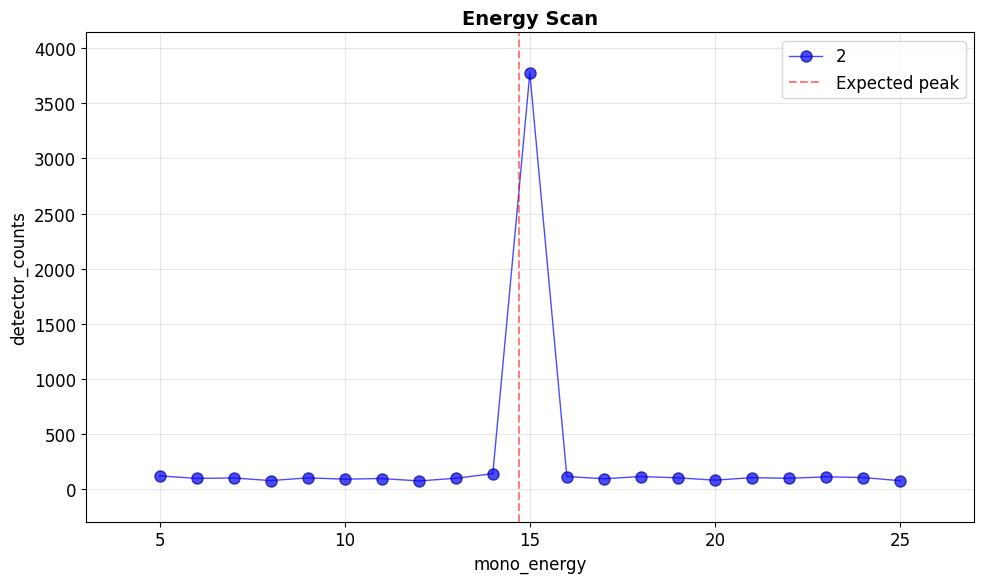


✅ Scan complete! UID: ('d7cccffc-f861-4a17-a12a-316af4c1c5b7',)
   Data points collected: 21


In [11]:
print("Executing scan with LivePlot...")
print("=" * 60)

# Clear previous data
data_storage.clear()

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
plot_callback = create_live_plot(ax=ax)

# Also add peak finder
peak_finder = create_peak_finder_callback(threshold=0.7)

# Execute scan with multiple callbacks
scan_uid = RE(
    scan(
        [detector], mono, 5, 25, 21, md={"sample": "test", "scan_type": "energy_fine"}
    ),
    [plot_callback, peak_finder],  # Multiple callbacks
)

# Enhance plot after scan
ax.axvline(14.7, color="red", linestyle="--", alpha=0.5, label="Expected peak")
ax.legend()
plt.tight_layout()
plt.show()

print(f"\n✅ Scan complete! UID: {scan_uid}")
print(f"   Data points collected: {len(data_storage)}")

## Results analysis

Data Analysis Results:
Total data points: 21
Energy range: 5.0 - 25.0 meV

Peak Analysis:
  Peak position: 15.00 meV
  Peak intensity: 3772 counts
  Expected peak: 14.7 meV
  Deviation: 0.30 meV


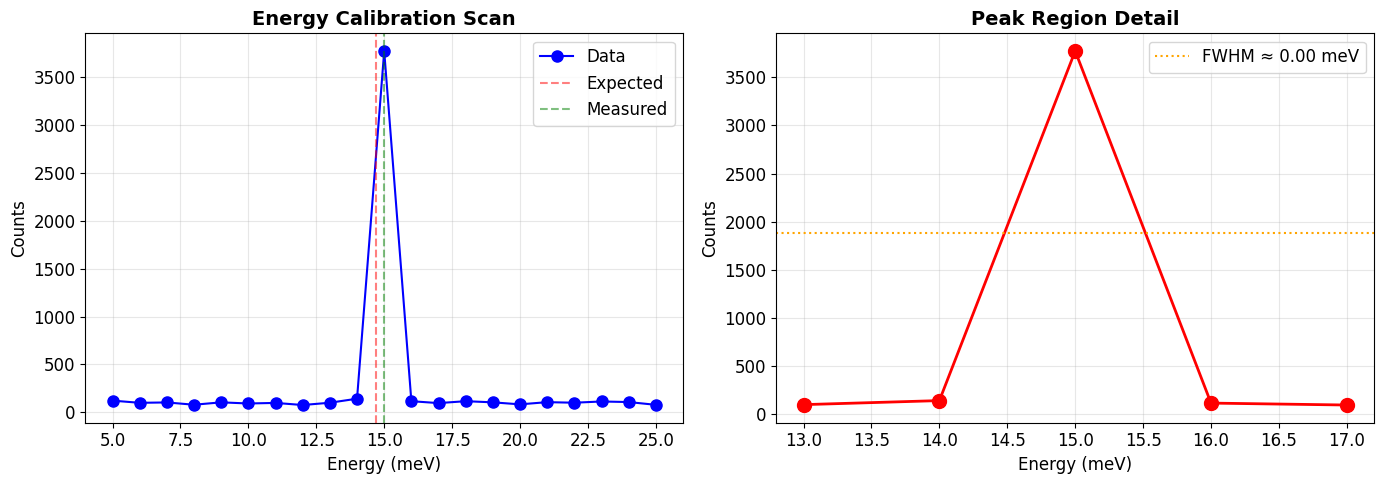


🎉 Demonstration Complete!

Key Takeaways:
  1. Virtual devices simulate real hardware behavior
  2. Always dry-run with summarize_plan() first
  3. Use check_limits() for safety
  4. LiveTable/LivePlot provide real-time feedback
  5. Data is automatically collected and can be analyzed

This workflow scales to real instruments!


In [12]:
# Extract and analyze the collected data
energies = [d["mono_energy"] for d in data_storage]
counts = [d["detector_counts"] for d in data_storage]

# Find peak
peak_idx = np.argmax(counts)
peak_energy = energies[peak_idx]
peak_counts = counts[peak_idx]

print("Data Analysis Results:")
print("=" * 60)
print(f"Total data points: {len(energies)}")
print(f"Energy range: {min(energies):.1f} - {max(energies):.1f} meV")
print("\nPeak Analysis:")
print(f"  Peak position: {peak_energy:.2f} meV")
print(f"  Peak intensity: {peak_counts:.0f} counts")
print("  Expected peak: 14.7 meV")
print(f"  Deviation: {abs(peak_energy - 14.7):.2f} meV")

# Create final analysis plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Full scan with fit
ax1.plot(energies, counts, "bo-", label="Data", markersize=8)
ax1.axvline(14.7, color="red", linestyle="--", alpha=0.5, label="Expected")
ax1.axvline(peak_energy, color="green", linestyle="--", alpha=0.5, label="Measured")
ax1.set_xlabel("Energy (meV)", fontsize=12)
ax1.set_ylabel("Counts", fontsize=12)
ax1.set_title("Energy Calibration Scan", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Zoom on peak region
peak_region = [(e, c) for e, c in zip(energies, counts) if abs(e - peak_energy) < 3]
if peak_region:
    peak_energies, peak_counts_zoom = zip(*peak_region)
    ax2.plot(peak_energies, peak_counts_zoom, "ro-", markersize=10, linewidth=2)
    ax2.set_xlabel("Energy (meV)", fontsize=12)
    ax2.set_ylabel("Counts", fontsize=12)
    ax2.set_title("Peak Region Detail", fontsize=14, fontweight="bold")
    ax2.grid(True, alpha=0.3)

    # Calculate and show FWHM
    half_max = peak_counts / 2
    above_half = np.array(counts) > half_max
    if np.any(above_half):
        indices = np.where(above_half)[0]
        fwhm = energies[indices[-1]] - energies[indices[0]]
        ax2.axhline(
            half_max, color="orange", linestyle=":", label=f"FWHM ≈ {fwhm:.2f} meV"
        )
        ax2.legend()

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("🎉 Demonstration Complete!")
print("\nKey Takeaways:")
print("  1. Virtual devices simulate real hardware behavior")
print("  2. Always dry-run with summarize_plan() first")
print("  3. Use check_limits() for safety")
print("  4. LiveTable/LivePlot provide real-time feedback")
print("  5. Data is automatically collected and can be analyzed")
print("\nThis workflow scales to real instruments!")
print("=" * 60)

## What's Next: From Virtual to Real Hardware

### 🔧 Transitioning to Real EPICS Hardware

The virtual devices in this demo use `Signal` for simulation. For real hardware connected via EPICS, you'll need to make these key changes:

#### 1. **Signal Classes for Real Hardware**

```python
# Virtual (this demo)
from ophyd import Signal

# Real EPICS hardware
from ophyd import EpicsSignal, EpicsSignalRO

# Usage:
# - Signal: Software-only signals (simulation, calculated values)
# - EpicsSignal: Read/write EPICS PVs
# - EpicsSignalRO: Read-only EPICS PVs
```

#### 2. **Converting the Energy Selector for Real Hardware**

```python
from ophyd import Device, Component as Cpt, EpicsSignal, EpicsSignalRO

class RealEnergySelectorDevice(Device):
    """Real monochromator connected to EPICS IOC."""
    
    # Real EPICS PVs - replace with your actual PV names
    energy = Cpt(EpicsSignal, 'Energy:RBV', write_pv='Energy:Set', kind="hinted")
    theta = Cpt(EpicsSignalRO, 'Theta:RBV', kind="config")
    two_theta = Cpt(EpicsSignalRO, 'TwoTheta:RBV', kind="config")
    moving = Cpt(EpicsSignalRO, 'Moving', kind="omitted")
    
    def __init__(self, prefix, name="mono", **kwargs):
        super().__init__(prefix=prefix, name=name, **kwargs)
        # Wait for PV connections
        self.wait_for_connection()

# Instantiate with your beamline's PV prefix
mono = RealEnergySelectorDevice('BL12:Mono:', name='mono')
```

#### 3. **Real Detector Example**

```python
class RealNeutronDetector(Device):
    """Real detector with EPICS control."""
    
    counts = Cpt(EpicsSignalRO, 'Counts', kind="hinted")
    exposure_time = Cpt(EpicsSignal, 'ExposureTime', kind="config")
    acquire = Cpt(EpicsSignal, 'Acquire', kind="omitted")
    
    def trigger(self):
        """Trigger real detector acquisition."""
        status = DeviceStatus(self)
        self.acquire.put(1)
        # Real detector would monitor 'Acquire' PV and set_finished() when done
        return status
```

### 📊 Data Management with Databroker

For production use, replace in-memory storage with databroker:

```python
from databroker import Broker

# Configure databroker (your facility should provide configuration)
db = Broker.named('your_beamline')

# Subscribe RunEngine to databroker
RE.subscribe(db.insert)

# Retrieve data after scan
run = db[-1]  # Get last run
data = run.primary.read()  # Access data as xarray
```

### 🔐 Safety and Interlocks

Real instruments require additional safety measures:

1. **Hardware Limits**: Set in EPICS IOC, not just in Ophyd
2. **Interlocks**: Implement beam shutters, sample environment checks
3. **Suspenders**: Pause scans on beam loss or safety violations

```python
from bluesky.suspenders import SuspendFloor

# Suspend if beam current drops below threshold
beam_current = EpicsSignalRO('BEAM:Current', name='beam_current')
sus = SuspendFloor(beam_current, 100)  # Suspend if < 100 mA
RE.install_suspender(sus)
```